# LPFP algorithm for MFGs with singular controls

## By Roxana Dumitrescu, Redouane Silvente and Peter Tankov


In this notebook we develop the *linear programming fictitious play algorithm* for MFGs with singular controls. 

The MFG problem for optimal stopping will be the following: 

i) Fix a flow of probability measures $m=(m_t)_{t\in [0, T]}$ on $\mathcal{B}(\mathcal{O})$ and a singular measure $\Lambda$ on $\mathcal{B}([0,T] \times \mathcal{O} \times A_1)$ , and find the solution to the singular optimal control 
\begin{equation}
\begin{aligned}
\sup_{\xi} & \quad \mathbb{E}\left[\int_{0}^{T} f_1\left(t, X^{m,\Lambda}_t, m_t\right) dt+ \int_{0}^{T} f_2\left(t, X^{m,\Lambda}_t, \Lambda,\delta \xi\right) d\xi_t + g\left(T, X^{m,\Lambda}_{T}, m_T\right)\right],\\
\text{s.t. } & \quad dX_{t}^{m,\Lambda}=b\left(t, X_{t}^{m,\Lambda}\right) dt+\sigma\left(t, X_{t}^{m,\Lambda}, m_t\right) dW_{t} - D\left(t, X_{t}^{m,\Lambda}\right)d\xi_t,,\\
& \quad X_0^{m}\sim m_0^*,
\end{aligned}
\end{equation}


ii) Given a solution $\xi^{m, \Lambda}$ of the above problem for the agent facing a mean-field $(m, \Lambda)$, find $(m,\Lambda)$ such that $m_t=\mathbb P\left(X^{m,\Lambda}_t\in \cdot\right)$ for all $t\in [0, T]$ and $\Lambda$ such that $\Lambda([0,t]\times B_1 \times B_2)=\mathbb{E} \int_0^t {1}_{B_1,B_2}(X_{s-},\delta \xi_s^{m,\Lambda}) d\xi^{m,\Lambda}_s, B_1\in \mathcal{B}(R), B_2 \in \mathcal{B}(A_1)$.


The inputs for the algorithm consist in the following data:

- An initial distribution of the players $m_0^*\in \mathcal P(\mathcal{O})$.
- A terminal horizon $T>0$.
- Functions $b$, $\sigma$, $f_1$,$f_2$ and $g$.
- Initial guess for the mean field $(\bar m^{(0)},\bar \Lambda^{(0)})$.
- Discretrization sets for $[0, T]$ and $R$.

At iteration $k$, the algorithm computes the best response $(\hat m^{(k+1)}, \hat \Lambda^{(k+1)})$ for a fixed distribution of the players $(\bar m^{(k)}, \bar \Lambda^{(k)})$ which influences the rewards. This step can be seen as a single-agent problem in the sense that for fixed $(\bar m^{(k)}, \bar \Lambda^{(k)})$, one solves a classical singular optimal control problem. Therefore, we use linear programming to compute the best response. 

Once the best response is calculated, we update our guess for the mean-field as it is suggested in the fictitious play framework:
$$(\bar m^{(k+1)}, \bar \Lambda^{(k+1)}):=\frac{k}{k+1}(\bar m^{(k)}, \bar \Lambda^{(k)}) + \frac{1}{k+1}(\hat m^{(k+1)}, \hat \Lambda^{(k+1)}).$$

We import the following packages

In [1]:
import numpy as np
from classes.reward import Reward
from classes.constraints import Constraints
from classes.problem import Problem
from reward_functions import *
from dynamic import *
from scipy.stats import norm
from config import initialize_config
from utils.matrix_verif import *
import pandas as pd
import matplotlib.pyplot as plt


All the parameters of the problem are defined in <span style="color:red">**Config.py**</span>.


In [2]:
config = initialize_config()

Time = config["Time"]
Delta = config["Delta"]
State = config["State"]
delta = config["delta"]
State_mesh_m = config["State_mesh_m"]
Time_mesh_m = config["Time_mesh_m"]
Time_mesh_lam = config["Time_mesh_lam"]
State_mesh_lam = config["State_mesh_lam"]
combined_state0 = config["combined_state0"]
combined_state1 = config["combined_state1"]
m0 = config["m0"]
U = config["U"]
d_t = config["d_t"]
d_s = config["d_s"]
d_j = config["d_j"]
tol = config["tol"]
N_iter = config["N_iter"]
m_tilde_0 = config["m_tilde_0"]
lam_tilde_0 = config["lam_tilde_0"]

# The fishermen case
In this problem, we work with two different state variables, $X$ represents the amount of fish in a given fishing zone and $J$ represents the action currently done by the fishermen. It can take the following values: 
1. $J=0$ means the fisherman does nothing.
2. $J=1$ means the fisherman starts fishing.

 The representative fisherman agent has the following dynamic:

$$
\begin{cases}
   \displaystyle dX_t^{J_t}=q(t,X_t^{J_t}, J_t)dt + \sigma(t,X_t^{J_t},J_t)dW_t\\
    dJ_t=(1-2J_t)d\xi_t
\end{cases}
$$
with 
$$
\begin{cases}
q(t,X_t^{0},0)=\kappa(t,X_t^{0}) \\
q(t,X_t^{1},1)=-K(t,X_t^{1}) 1_{X_t^{1}>0} 
\end{cases}
$$
## 1) Best response

We start with the best response algorithm via linear programming.

### Discretization of the time space

We discretize the time space by 
$$t_i=\frac{iT}{n_t}, \quad i\in \{0, 1, \ldots n_t\},$$
where $n_t\in \mathbb N^*$. We denote $\Delta =T/n_t$. 

### Discretization of the state space

We assume that $\mathcal{O}=(\underline x, \overline x) \times \{0,1\}$. We discretize the state space with $n_s+1$ points $\underline x = x_0< x_1< \ldots < x_{n_s} = \overline x$, where $n_s\in \mathbb N^*$. We denote
$$\delta_p=x_p-x_{p-1}, \quad p\in \{1, \ldots, n_s\}.$$

We suppose that the points are equally separated with separation $\delta$. We recall that the $j$ are only separated by one.

### Discretization of the initial distribution

The initial state distribution $m_0^*$ is approximated by convex combinations of dirac masses on the discretization of $\mathcal{O}$. The discretized initial state distribution will be denoted in the code by m0 and it will be a vector of $2*(n_s+1)$ components indicating the mass for each $(x_p,j)$, $p\in\{0, \ldots, x_{n_s}\}, j=0,1$.

### Drift, volatility and reward functions

We are given functions $(t, x)\mapsto (b, \sigma, f_1,f_2, g)(t, x,j)$. They are defined in the <span style="color:red">**dynamic.py**</span> file.

### Discretized Generator and test functions
The constraints are built in the file <span style="color:red">**constraints.py**</span>.
We define
$$Au(t, x,j)=\frac{\partial u}{\partial t}(t, x,j) + b(t, x,j)\frac{\partial u}{\partial x}(t, x,j) + \frac{\sigma^2}{2}(t, x,j)\frac{\partial^2 u}{\partial x^2}(t, x,j), \quad \forall u\in \mathcal{D}(L):=C^{1, 2}_b([0, T]\times \bar{\mathcal{O}})$$
and 
$$Bu(t,x,j)=u(t,x,1-j)-u(t,x ,j). $$
We set $\mathcal{D}(\hat L)$ as the functions in $\mathcal{D}(L)=C^{1, 2}_b([0, T]\times \bar{\mathcal{O}})$ restricted to the discretization Time-State. 

We discretize the derivatives for $u\in \mathcal{D}(\hat L)$ as follows: for $i\in\{0, 1, \ldots, n_t-1\}$ and $p\in\{1, \ldots, n_s-1\}$,
$$\hat A_t u (t_i, x_p,j)= \frac{1}{\Delta}[u(t_{i+1}, x_p,j)-u(t_i, x_p,j)],$$
$$\hat A_x^u u (t_i, x_p,j)=\frac{1}{\delta}\max(b(t_i, x_p,j), 0)[u(t_{i+1}, x_{p+1},j)-u(t_{i+1}, x_p,j)],$$
$$\hat A_x^d u (t_i, x_p,j)=\frac{1}{\delta}\min(b(t_i, x_p,j), 0)[u(t_{i+1}, x_p,j)-u(t_{i+1}, x_{p-1},j)],$$
$$\hat A_{xx} u (t_i, x_p,j)=\frac{1}{\delta^2}\frac{\sigma^2}{2}(t_i, x_p,j)[u(t_{i+1}, x_{p+1},j) + u(t_{i+1}, x_{p-1},j)-2u(t_{i+1}, x_p,j)].$$
The discretized generators have the form:
$$\hat A u (t_i, x_p,j) = \hat A_t u (t_i, x_p,j) + \hat A_x^u u (t_i, x_p,j) + \hat A_x^d u (t_i, x_p,j) + \hat A_{xx} u (t_i, x_p,j)$$ 
and
$$\hat Bu(t_i,x_p,j)=u(t_i,x_p,j)-u(t_i,x_p,1-j)$$

The constraint reads as
<!-- $$
\sum_{i=0}^{n_t}\sum_{j=0}^{n_s} u(t_i, x_p)\hat\lam(t_i, x_p) - \Delta\sum_{i=0}^{n_t-1}\sum_{j=1}^{n_s-1} \hat L u(t_i, x_p) \hat m(t_i, x_p) = \sum_{j=0}^{n_s}u(t_0, x_p) m_0(x_p), \tag{1}
$$ -->
$$
\sum_{p=1}^{n_s-1}\sum_{j=0}^{1}u(T,x_p,j)\hat m(T,x_p,j)-\Delta  \sum_{i=0}^{n_t-1}\sum_{p=1}^{n_s-1}\sum_{j=0}^{1}\hat A u(t_i,x_p,j)\hat m(t_j,x_p,j) -   \sum_{i=0}^{n_t}\sum_{p=0}^{n_s}\sum_{j=0}^{1}\hat B u(t_j,x_p,j) \hat \Lambda(t_i,x_p,j)= \sum_{p=1}^{n_s-1}\sum_{j=0}^{1}u(0,x_p,j) \hat m_0(x_p,j)
$$
for $u\in \mathcal{D}(\hat L)$.

The set $\mathcal{D}(\hat L)$ is equal to the linear span of the indicators functions 
$$\mathbf{1}_{\{(t_i, x_p,j)\}}, \quad i\in\{0, 1, \ldots, n_t\}, \; p\in\{0, 1, \ldots, n_s\}, \; j=0,1$$ 
on the Time-State grid. By linearity, it suffices to evaluate the constraint on the set of indicator functions.

Stacking all the indicator functions evaluated in the Time-State grid by rows we get the following matrix:
$$U=
\begin{bmatrix}
u_{1}(t_0, x_0,0) & \ldots & u_{1}(t_0, x_{n_s},0) & u_{1}(t_0, x_0,1) & \ldots & u_{1}(t_0, x_{n_s},1) & \ldots & u_1(t_{n_t}, x_{n_s},1)\\
\vdots & & & & \vdots\\
u_{n_f}(t_{0}, x_0,0) & \ldots & u_{n_f}(t_{0}, x_{n_s},0) & u_{n_f}(t_0, x_0,1) & \ldots & u_{n_f}(t_0, x_{n_s},1) & \ldots & u_{n_f}(t_{n_t}, x_{n_s},1)
\end{bmatrix},
$$
where $n_f$ is the total number of indicator functions. This matrix will be used to define the constraints.

We write the constraint (1) in the following form
$$A_{eq} z = b_{eq},$$
where $A_{eq}$ is a matrix and $z$ and $b_{eq}$ are 2 vectors.

In our case, we will set $z=(z_{m1},z_{m2}, z_{lam})^T$
$$z_{lam}=\left[ 
\hat{\Lambda}(t_0, x_1, 0), \ldots, \hat{\Lambda}(t_0, x_{n_s-1}, 0), \hat{\Lambda}(t_0, x_1, 1), \ldots, \hat{\Lambda}(t_0, x_{n_s-1}, 1), \ldots, 
\hat{\Lambda}(t_{n_t}, x_1, 0), \ldots, \hat{\Lambda}(t_{n_t}, x_{n_s-1}, 0), \hat{\Lambda}(t_{n_t}, x_1, 1), \ldots, \hat{\Lambda}(t_{n_t}, x_{n_s-1}, 1) 
\right],$$
$$z_{m1} = \left[ 
\hat{m}(t_0, x_1, 0), \ldots, \hat{m}(t_0, x_{n_s-1}, 0), \hat{m}(t_0, x_1, 1), \ldots, \hat{m}(t_0, x_{n_s-1}, 1), \ldots, 
\hat{m}(t_{n_t}, x_1, 0), \ldots, \hat{m}(t_{n_t}, x_{n_s-1}, 0), \hat{m}(t_{n_t}, x_1, 1), \ldots, \hat{m}(t_{n_t}, x_{n_s-1}, 1) 
\right]$$
$$
z_{m2} =[\hat m(t_{n_t}, x_1,0), \ldots, \hat m(t_{n_t}, x_{n_s-1},0), \ldots, \hat m(t_{n_t}, x_1,1), \ldots, \hat m(t_{n_t}, x_{n_s-1},1)].
$$
We also set $A_{eq}=[A_{eq}^{m1},A_{eq}^{m2}, A_{eq}^{lam}]$, where
$$A_{eq}^{m1}= -\Delta\times
\begin{bmatrix}
\hat A u_{1}(t_0, x_1,0) & \ldots & \hat A u_{1}(t_0, x_{n_s-1},0) & A u_{1}(t_0, x_1,1) & \ldots & \hat A u_{1}(t_0, x_{n_s-1},1)& \ldots &\hat A u_{1}(t_{n_t-1}, x_1,0) & \ldots & \hat A u_{1}(t_{n_t-1}, x_{n_s-1},0) & A u_{1}(t_{n_t-1}, x_1,1) & \ldots & \hat A u_{1}(t_{n_t-1}, x_{n_s-1},1)\\
\vdots & & & & & & & &  & & & \vdots\\
\hat A u_{n_f}(t_0, x_1,0) & \ldots & \hat A u_{n_f}(t_0, x_{n_s-1},0) & A u_{n_f}(t_0, x_1,1) & \ldots & \hat A u_{n_f}(t_0, x_{n_s-1},1)& \ldots &\hat A u_{n_f}(t_{n_t-1}, x_1,0) & \ldots & \hat A u_{n_f}(t_{n_t-1}, x_{n_s-1},0) & A u_{n_f}(t_{n_t-1}, x_1,1) & \ldots & \hat A u_{n_f}(t_{n_t-1}, x_{n_s-1},1)
\end{bmatrix}
$$
$$A_{eq}^{m2}=\begin{bmatrix}
u_{1}(t_{n_t}, x_0,0) & \ldots & u_{1}(t_{n_t}, x_{n_s},0) & u_{1}(t_{n_t}, x_0,1) & \ldots & u_{1}(t_{n_t}, x_{n_s},1)\\
\vdots & & & & & \vdots\\
u_{n_f}(t_{n_t}, x_0,0) & \ldots & u_{n_f}(t_{n_t}, x_{n_s},0) & u_{n_f}(t_{n_t}, x_0,1) & \ldots & u_{n_f}(t_{n_t}, x_{n_s},1)
\end{bmatrix},
$$
and 
$$
A_{eq}^{lam}=-
\begin{bmatrix}
\hat B u_{1}(t_0, x_1,0) & \ldots & \hat B u_{1}(t_0, x_{n_s-1},0) & B u_{1}(t_0, x_1,1) & \ldots & \hat B u_{1}(t_0, x_{n_s-1},1)& \ldots &\hat B u_{1}(t_{n_t-1}, x_1,0) & \ldots & \hat B u_{1}(t_{n_t-1}, x_{n_s-1},0) & B u_{1}(t_{n_t}, x_1,1) & \ldots & \hat B u_{1}(t_{n_t}, x_{n_s-1},1)\\
\vdots & & & & & & & &  & & & \vdots\\
\hat B u_{n_f}(t_0, x_1,0) & \ldots & \hat B u_{n_f}(t_0, x_{n_s-1},0) & B u_{n_f}(t_0, x_1,1) & \ldots & \hat B u_{n_f}(t_0, x_{n_s-1},1)& \ldots &\hat B u_{n_f}(t_{n_t-1}, x_1,0) & \ldots & \hat B u_{n_f}(t_{n_t}, x_{n_s-1},0) & B u_{n_f}(t_{n_t}, x_1,1) & \ldots & \hat B u_{n_f}(t_{n_t-1}, x_{n_s-1},1)
\end{bmatrix}
$$
We define 
$$b_{eq}=[u_1(t_0, \cdot,\cdot)^Tm_0, \ldots, u_{n_f}(t_0, \cdot,\cdot)^T m_0]^T$$


### Reward

The reward is built in <span style="color:red">**reward.py**</span>. It is given by

$$
\Delta\sum_{i=0}^{n_t-1}\sum_{p=1}^{n_s-1}\sum_{j=0}^{1}f_1(t_i,x_p,j)\hat m(t_i,x_p,j)+\Delta\sum_{i=0}^{n_t-1}\sum_{p=1}^{n_s-1}\sum_{j=0}^{1}f_2(t_i,x_p,j)\hat \Lambda(t_i,x_p,j) + \sum_{p=1}^{n_s-1}\sum_{j=0}^{1}g(T,x_p,j)\hat m(T,x_p,j)
$$
We will minimize the function $c^Tz$ subject to the constraint $A_{eq} z = b_{eq}$, where $c$ is a vector of costs. We will set $c=(r_{m1},r_{m2}, r_{lam})^T$, where
$$r_{m1} = \Delta \times [f_1(t_0, x_1,0), \ldots, f_1(t_0, x_{n_s-1},0), f_1(t_1, x_1,0), \ldots, f_1(t_1, x_{n_s-1},0), \ldots, f_1(t_{n_t-1}, x_{n_s-1},0),f_1(t_0, x_1,1), \ldots, f_1(t_0, x_{n_s-1},1), f_1(t_1, x_1,1), \ldots, f_1(t_1, x_{n_s-1},1), \ldots, f_1(t_{n_t-1}, x_{n_s-1},1)],$$
$$r_{m2}=[g(t_{n_t}, x_0,0), \ldots, g(t_{n_t}, x_{n_s},0), g(t_{n_t}, x_0,1), \ldots, g(t_{n_t}, x_{n_s},1)],$$
and
$$
r_{lam} =  \Delta\times[f_2(t_0, x_1,0), \ldots, f_2(t_0, x_{n_s-1},0), f_2(t_1, x_1,0), \ldots, f_2(t_1, x_{n_s-1},0), \ldots, f_2(t_{n_t-1}, x_{n_s-1},0),f_2(t_0, x_1,1), \ldots, f_2(t_0, x_{n_s-1},1), f_2(t_1, x_1,1), \ldots, f_2(t_1, x_{n_s-1},1), \ldots, f_2(t_{n_t-1}, x_{n_s-1},1)],
$$

In [3]:
def initialize_reward_and_constraints():
    """
    Initialize the Reward and Constraints objects.
    """
    # Define the reward functions
    f1 = f1_factory(m_tilde_0,State,Time)
    f2 = f2_factory(lam_tilde_0,State,Time)
    g = g_factory(m_tilde_0,State)

    # Create a Reward object
    reward = Reward(State_mesh_m, Time_mesh_m, State_mesh_lam, Time_mesh_lam, State, Delta, delta, f1, f2, g)

    # Define the drift term
    b=b_factory(Time,State)
    # Define the diffusion term
    sigma=s_factory(Time,State)
    # Create a Constraints object
    constraints = Constraints(State_mesh_m, Time_mesh_m,State_mesh_lam, Time_mesh_lam,State,Time ,Delta, delta,U , m0, b, sigma)

    return reward, constraints

For the problem to be well defined, $\delta$ and $\Delta$ should satisfy:
$$\Delta\leq \frac{\delta^2}{\sigma^2(t_i, x_j) + \delta |b|(t_i, x_j)}, \quad \forall (i, j).$$

In [4]:
print((delta**2/(1+delta))-Delta)
print('Delta:',Delta)
print('delta:',delta)

0.4
Delta: 0.1
delta: 1.0


## 2) Fictitious Play iteration

The optimisation is performed in <span style="color:red">**problem.py**</span>. Here we present the Fictitious Play iteration of the best responses approximating the LP MFG Nash equilibrium. We give two possibilities to track the convergence of the algorithm. The first one is the exploitability:
$$\varepsilon(\bar m, \bar \Lambda):=\sup_{(m, \Lambda)}\langle m-\bar m, f_1[\bar m]\rangle + \langle \Lambda-\bar \Lambda, f_2[\bar \Lambda]\rangle,$$
where the supremum is taken over the measures satisfying the constraint. The second one is a distance between the measures:
$$d((\Lambda, m),(\bar\Lambda, \bar m)):=\max\left\{\Delta \sum_{i,p, j}|m(t_i, x_p,j) - \bar m(t_i, x_p,j)|, \sum_{i,p, j}|\Lambda(t_i, x_p,j) - \bar \Lambda(t_i, x_p,j)|\right\}.$$



## 3) Results

We collect the results via the main function. 

In [5]:
def main():
    # Initialize the Reward and Constraints objects
    reward, constraints = initialize_reward_and_constraints()
    # for i in range(0,constraints.A_eq.shape[0]):
    #     print(constraints.A_eq[i,:].todense())

    # Create a Problem object
    problem = Problem(State_mesh_m,Time_mesh_m,State_mesh_lam,Time_mesh_lam,m_tilde_0, lam_tilde_0,State,Time ,Delta, delta, constraints, reward,tol,N_iter,f1_factory,f2_factory,g_factory)

    # Compute the optimal solution
    value, lam_bar, m_bar, lam_hat, m_hat, eps_array = problem.compute_optimal_solution()
    
    return value, lam_bar, m_bar, lam_hat, m_hat, eps_array


In [6]:
value, lam_bar, m_bar, lam_hat, m_hat, eps_array = main()

Set parameter Username
Set parameter LicenseID to value 2606933
Academic license - for non-commercial use only - expires 2026-01-07
Set parameter LogToConsole to value 0
Set parameter LogToConsole to value 0
Iteration:    1; Error:  1.295521
Set parameter LogToConsole to value 0
Iteration:    2; Error:  9.864959
Set parameter LogToConsole to value 0
Iteration:    3; Error:  4.505833
Set parameter LogToConsole to value 0
Iteration:    4; Error:  2.612253
Set parameter LogToConsole to value 0
Iteration:    5; Error:  1.722869
Set parameter LogToConsole to value 0
Iteration:    6; Error:  1.235054
Set parameter LogToConsole to value 0
Iteration:    7; Error:  0.936590
Set parameter LogToConsole to value 0
Iteration:    8; Error:  0.739595
Set parameter LogToConsole to value 0
Iteration:    9; Error:  0.603434
Set parameter LogToConsole to value 0
Iteration:   10; Error:  0.505185
Set parameter LogToConsole to value 0
Iteration:   11; Error:  0.431154
Set parameter LogToConsole to value 0


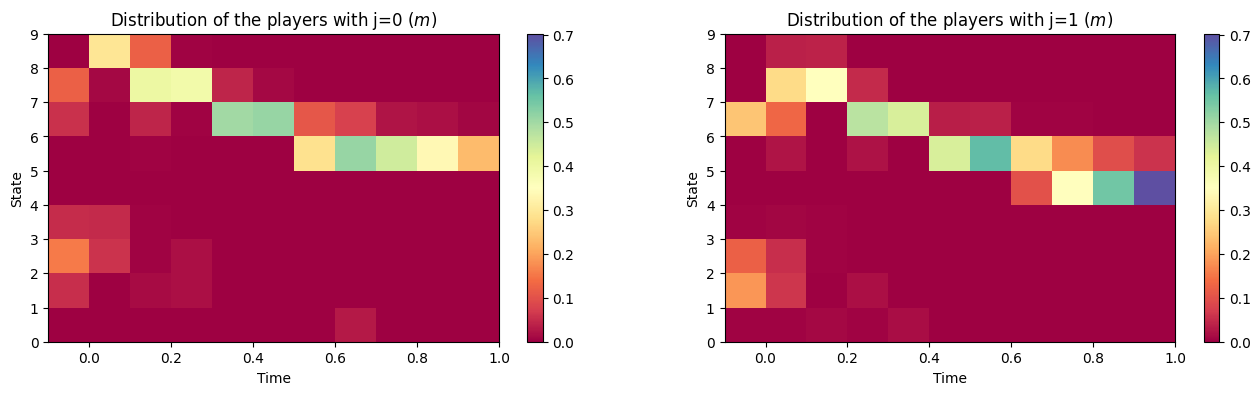

In [13]:
x_m, y_m = np.meshgrid(Time[:, 0]- Delta/2, State[1:d_s-1, 0]- delta/2, indexing='ij') # Depends on the version of matplotlib

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(1, 2, 1)  
ax2 = fig.add_subplot(1, 2, 2)


c1 = ax1.pcolormesh(x_m, y_m, m_bar[:,:,0], cmap='Spectral', vmin = m_bar.min(),
                          vmax = m_bar.max())

ax1.set_xlabel("Time")                     
ax1.set_ylabel("State")                     
ax1.set_title("Distribution of the players with j=0 ($m$)")
c2 = ax2.pcolormesh(x_m, y_m, m_bar[:,:,1], cmap='Spectral', vmin = m_bar.min(),
                          vmax = m_bar.max())

ax1.set_xlabel("Time")                     
ax1.set_ylabel("State")                     
ax1.set_title("Distribution of the players with j=0 ($m$)")
fig.colorbar(c1, ax = ax1)

ax2.set_xlabel("Time")                     
ax2.set_ylabel("State")                     
ax2.set_title("Distribution of the players with j=1 ($m$)")
fig.colorbar(c2, ax = ax2)

In [8]:
print("Value: ", value)
print("lam_bar: ", lam_bar)
print("m_bar: ", m_bar)
print("lam_hat: ", lam_hat)
print("m_hat: ", m_hat)
print("eps_array: ", eps_array)

Value:  8.344822551247596
lam_bar:  [[[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 2.32555788e-04  4.42629165e-02]
  [ 2.42796836e-04  4.75231462e-05]
  [ 3.25973961e-06  1.66871103e-07]
  [ 0.00000000e+00  0.00000000e+00]
  [ 6.67484412e-05  2.21593081e-03]
  [ 2.69202655e-02  6.38397372e-02]
  [ 0.00000000e+00  5.45979532e-04]
  [ 2.46700876e-02  2.20487879e-03]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 3.11098569e-02  2.70069429e-01]
  [ 2.94538483e-01  3.60613105e-02]
  [ 0.00000000e+00  0.00000000e+00]
  [ 1.66871103e-07  5.18544766e-06]
  [ 2.56822464e-02  2.60522049e-01]
  [ 2.54022023e-04  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  4.02086632e-07]
  [ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.84292603e-03]
  [ 2.50169405e-01  5.37